<a href="https://colab.research.google.com/github/shloksah/Kaggle_hackathons/blob/main/Customer360_Google_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏦 **Customer360 AI Platform with BigQuery ML**  

✨ *“An AI-powered platform that helps bankers and service reps deliver the best customer experience, while enabling business leaders to launch products confidently and monitor overall customer health”*  

🔗 Google Hackathon Kaggle – [BigQuery AI Hackathon](https://www.kaggle.com/competitions/bigquery-ai-hackathon/overview)  

---

## ❓ **Problem Statement**  
The financial services industry is more competitive than ever.  
Banks must not only:  
- 🧑‍🤝‍🧑 Retain existing customers  
- 🛡 Safeguard against fraud  
- 📊 Anticipate demand  
- 🎯 Deliver highly personalized recommendations in real time  

---

## 🎯 **Goals**  
The goal of this project is to serve both **Bankers** and **Customer Service Specialists**.  

With the banking space becoming increasingly competitive, quick and efficient service is the need of the hour. Every bank aims to capture affluent customers, and this is possible only if we provide them with fast, seamless support—whether they are calling in 📞 or interacting with a banker at a branch 🏦.  

👉 In this project, we designed a **Customer360 AI Platform on BigQuery ML** to unify these challenges into a single, scalable solution.  

By leveraging Google BigQuery’s serverless analytics ⚡, forecasting 📈, clustering 🔍, and generative AI 🤖 integrations, our platform empowers bankers and customer service specialists to understand and serve customers at the point of interaction.  

---

## 💥 **Impact**  
- 🧑‍🤝‍🧑 **Customer Retention**: Identify churn risk early and prevent revenue leakage.  
- 🛡 **Fraud Detection**: Safeguard trust and reduce financial losses.  
- 📊 **Demand Forecasting**: Predict future spend to optimize resource allocation and campaigns.  
- 🎁 **Personalized Recommendations**: Suggest relevant products tailored to customer clusters.  
- 🌐 **360-Degree View**: Combine all signals with AI-generated insights for next-best-action.  

## ⚙️ Project Workflow

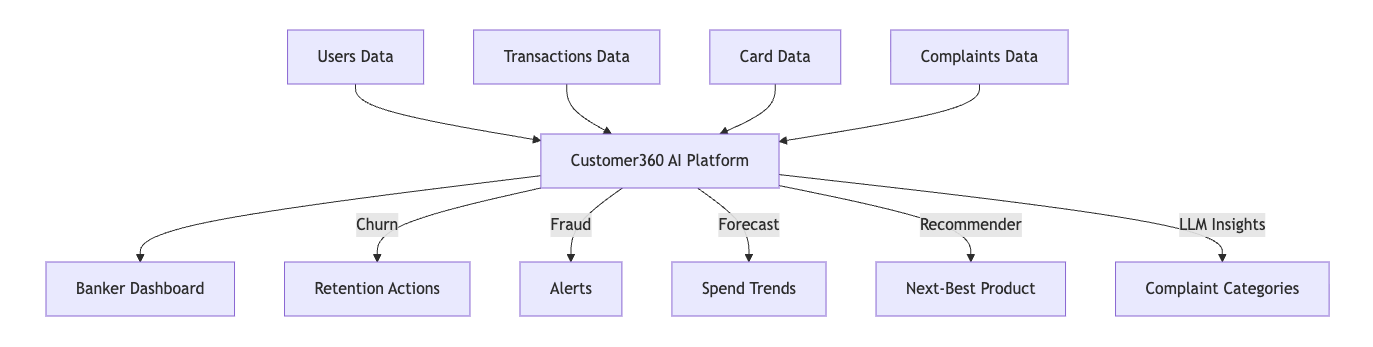


---

### 📂 **Data Sources**  
We built the prototype using **Kaggle’s Transactions Fraud Dataset** and complementary public datasets, sampled and transformed to mimic a real banking environment.  
🔗 [Dataset Link](https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets)  

- 💳 **Transaction Data** – Detailed transactions with fraud labels  
- 🏷 **Cards Data** – Card type and product information  
- 👤 **Users Data** – Demographics including age, income, and location  
- 🏪 **MCC Codes** – Merchant category classification for spending analysis  
- 📑 **CFPB Complaints Data** – Consumer complaints for LLM-driven tagging  

---

In [5]:
!pip install --upgrade google-cloud-bigquery
from google.colab import auth
auth.authenticate_user()
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.express as px
# Initialize client
client = bigquery.Client(project="sunny-hope-315311")  # replace with your GCP project ID


## 🛠 **Data Preparation**  

## 👥 **Client Base**  
- 🆔 Created a Client ID sample to build a smaller C360 prototype dataset using Fraud/Non-Fraud cases.  
- 💡 Sample helps to showcase BigQuery LLM generation features without incurring high billing costs.  
- 🔗 Introduced a Client ID Proxy to join datasets lacking natural keys across different data sources.  
- ⚙️ Designed with flexibility—imaginary tables can be replaced with real banking data while keeping the same process and logic.  

---



In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.sample_client_ids` AS
WITH fraud_ids AS (
  SELECT DISTINCT A.CLIENT_ID
  FROM `my_database.transactions_data` a left join `my_database.train_fraud_labels` b on CAST(a.id AS NUMERIC) = CAST(b.id AS NUMERIC)
  WHERE fraud_label is TRUE
),
nonfraud_ids AS (
  SELECT DISTINCT A.CLIENT_ID
  FROM `my_database.transactions_data` a left join `my_database.train_fraud_labels` b on CAST(a.id AS NUMERIC) = CAST(b.id AS NUMERIC)
  WHERE fraud_label is FALSE
  AND A.CLIENT_ID NOT IN (SELECT CLIENT_ID FROM fraud_ids) -- exclude overlap
),
fraud_sample AS (
  SELECT CLIENT_ID
  FROM fraud_ids
  ORDER BY RAND()
  LIMIT 100
),
nonfraud_sample AS (
  SELECT CLIENT_ID
  FROM nonfraud_ids
  ORDER BY RAND()
  LIMIT 100
),
combine_sample as
(SELECT CLIENT_ID FROM fraud_sample
UNION ALL
SELECT CLIENT_ID FROM nonfraud_sample)
SELECT CLIENT_ID, ROW_NUMBER() OVER (ORDER BY CLIENT_ID) AS CLIENT_ID_PROXY FROM combine_sample;
"""

client.query(query).result()
print("✅ Table created successfully")

In [ ]:
df_samples = client.query("SELECT * FROM my_database.sample_client_ids").to_dataframe()
print(df_samples.shape)
df_samples.head()

(123, 2)


,CLIENT_ID,CLIENT_ID_PROXY
0,319,27
1,477,36
2,797,62
3,855,65
4,1510,99


## 💳 **Transaction Data w/ MCC Codes**  
- 📅 Sampled transaction data (2010–2020) for the selected client IDs.  
- 💳 Data simulates real credit/debit card usage across US merchants, with fraud labels for flagged transactions.  
- 📊 Features include transaction counts and amounts per client for spend forecasting and C360 assistant.  
- 🏪 Uses MCC codes from `greggles/mcc-codes`.  

---


In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.transactions_data_sampled` AS
(SELECT a.* except(id), a.id as transaction_id, case when b.fraud_label then 1 else 0 end as fraud_label
FROM `my_database.transactions_data` a left join `my_database.train_fraud_labels` b on CAST(a.id AS NUMERIC) = CAST(b.id AS NUMERIC)
where a.client_id in (select client_id from `my_database.sample_client_ids`));
"""

client.query(query).result()
print("✅ Table created successfully")

In [9]:
df_transactions = client.query("select * from `my_database.transactions`").to_dataframe()
print(df_transactions.shape)
df_transactions.head()

(1272636, 13)


,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,transaction_id,fraud_label
0,2015-01-23 15:59:00+00:00,729,226,6.46,Chip Transaction,19,Philadelphia,PA,19130.0,5813,None,15576155,0
1,2018-02-04 06:52:00+00:00,1177,4860,4.69,Chip Transaction,22,Newark,DE,19711.0,5812,None,20766094,0
2,2019-02-21 06:44:00+00:00,1177,4016,5.69,Chip Transaction,22,Newark,DE,19711.0,5812,None,22567463,0
3,2015-02-03 09:08:00+00:00,1177,4860,12.31,Chip Transaction,22,Newark,DE,19711.0,5812,None,15624921,0
4,2010-08-08 08:36:00+00:00,1177,4164,11.49,Swipe Transaction,22,Newark,DE,19711.0,5812,None,8357814,0


#### **MCC Codes**

In [10]:
df_mcc = pd.read_csv("https://raw.githubusercontent.com/greggles/mcc-codes/main/mcc_codes.csv")
df_transactions_w_mcc = pd.merge(df_transactions, df_mcc, on='mcc', how='left')
df_transactions_w_mcc

,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,transaction_id,fraud_label,edited_description,combined_description,usda_description,irs_description,irs_reportable
0,2015-01-23 15:59:00+00:00,729,226,6.46,Chip Transaction,19,Philadelphia,PA,19130.0,5813,None,15576155,0,"Drinking Places (Alcoholic Beverages), Bars, T...","Drinking Places (Alcoholic Beverages), Bars, T...","Drinking Places (Alcoholic Beverages), Bars, T...",Drinking Places,No1.6041-3(c)
1,2018-02-04 06:52:00+00:00,1177,4860,4.69,Chip Transaction,22,Newark,DE,19711.0,5812,None,20766094,0,Eating places and Restaurants,Eating places and Restaurants,Eating places and Restaurants,"Eating Places, Restaurants",No1.6041-3(c)
2,2019-02-21 06:44:00+00:00,1177,4016,5.69,Chip Transaction,22,Newark,DE,19711.0,5812,None,22567463,0,Eating places and Restaurants,Eating places and Restaurants,Eating places and Restaurants,"Eating Places, Restaurants",No1.6041-3(c)
3,2015-02-03 09:08:00+00:00,1177,4860,12.31,Chip Transaction,22,Newark,DE,19711.0,5812,None,15624921,0,Eating places and Restaurants,Eating places and Restaurants,Eating places and Restaurants,"Eating Places, Restaurants",No1.6041-3(c)
4,2010-08-08 08:36:00+00:00,1177,4164,11.49,Swipe Transaction,22,Newark,DE,19711.0,5812,None,8357814,0,Eating places and Restaurants,Eating places and Restaurants,Eating places and Restaurants,"Eating Places, Restaurants",No1.6041-3(c)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272631,2017-09-19 18:23:00+00:00,990,5038,44.91,Chip Transaction,100340,Donaldsonville,LA,70346.0,5812,None,20117854,0,Eating places and Restaurants,Eating places and Restaurants,Eating places and Restaurants,"Eating Places, Restaurants",No1.6041-3(c)
1272632,2014-02-21 17:15:00+00:00,990,5038,47.69,Swipe Transaction,100340,Donaldsonville,LA,70346.0,5812,None,14035541,0,Eating places and Restaurants,Eating places and Restaurants,Eating places and Restaurants,"Eating Places, Restaurants",No1.6041-3(c)
1272633,2012-05-12 17:12:00+00:00,990,5038,50.31,Swipe Transaction,100340,Donaldsonville,LA,70346.0,5812,None,11115478,0,Eating places and Restaurants,Eating places and Restaurants,Eating places and Restaurants,"Eating Places, Restaurants",No1.6041-3(c)
1272634,2018-10-23 17:18:00+00:00,990,5038,42.02,Chip Transaction,100340,Donaldsonville,LA,70346.0,5812,None,21999384,0,Eating places and Restaurants,Eating places and Restaurants,Eating places and Restaurants,"Eating Places, Restaurants",No1.6041-3(c)


/tmp/ipython-input-216689758.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='irs_description', data=irs_description_counts, palette='viridis')


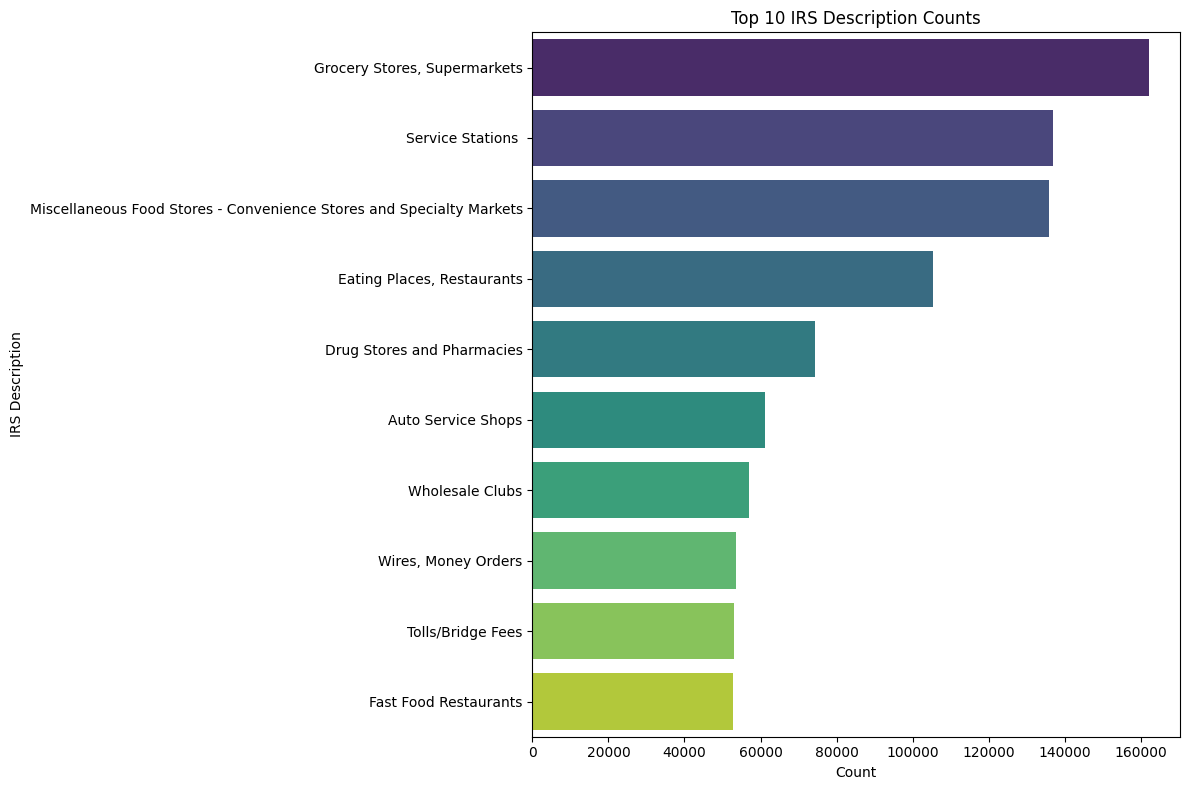

In [ ]:
# Count the occurrences of each irs_description
irs_description_counts = df_transactions_w_mcc['irs_description'].value_counts().reset_index()
irs_description_counts.columns = ['irs_description', 'count']

# Select the top N descriptions for clarity (optional)
top_n = 10
irs_description_counts = irs_description_counts.head(top_n)

# Create a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='irs_description', data=irs_description_counts, palette='viridis')
plt.title(f'Top {top_n} IRS Description Counts')
plt.xlabel('Count')
plt.ylabel('IRS Description')
plt.tight_layout()
plt.show()


## 📑 **Complaints Data**  
- 📂 Sampled data for each product type to ensure enriched coverage across categories.  
- 📉 Distribution may not reflect natural complaint patterns, but supports prototyping with complete client data.  
- 💵 Reduced complaint volume to lower Vertex AI (`AI.GENERATE`) costs.  
- 🤖 Prepared dataset enables future AI-based complaint tagging.  

---


In [ ]:
query = """CREATE OR REPLACE TABLE `my_database.complaints_sampled` AS
WITH COMPLAINTS_SAMPLING AS
(
  SELECT *, ROW_NUMBER() OVER(PARTITION BY PRODUCT ORDER BY RAND()) AS RNO FROM `bigquery-public-data.cfpb_complaints.complaint_database`
  where consumer_complaint_narrative is not null
)
SELECT A.* EXCEPT(client_id_proxy),B.client_id
FROM(
      SELECT * EXCEPT(RNO), ROW_NUMBER() OVER (ORDER BY rand()) AS client_id_proxy
      FROM COMPLAINTS_SAMPLING WHERE RNO <=7
    ) a
    inner join `my_database.sample_client_ids` b
    on CAST(a.CLIENT_ID_PROXY AS NUMERIC) = CAST(b.CLIENT_ID_PROXY AS NUMERIC);

"""

client.query(query).result()
print("✅ Table created successfully")

In [ ]:
df_complaints = client.query("select * from my_database.complaints_tagging").to_dataframe()
print(df_complaints.shape)
df_complaints.head()

(123, 20)


,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,client_id,summary
0,2015-05-11,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",None,"In XXXX, we began working with CitiMortgage to...",None,"CITIBANK, N.A.",FL,33710,None,Consent provided,Web,2015-05-11,Closed with explanation,True,False,1369612,846,CitiMortgage's failed loan modification led to...
1,2015-05-20,Money transfers,Domestic (US) money transfer,Other service issues,None,PayPal enrolled me in PayPal Credit without me...,None,"Paypal Holdings, Inc",GA,30044,None,Consent provided,Web,2015-05-20,Closed with monetary relief,True,False,1384357,688,"PayPal credit enrollment, misbilling, and bank..."
2,2015-05-24,Credit card,None,Identity theft / Fraud / Embezzlement,None,"In XX/XX/XXXX, I invested in a website and lif...",Company chooses not to provide a public response,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,34982,Older American,Consent provided,Web,2015-05-28,Closed with explanation,True,True,1390413,65,Bank denied fraud claim for credit card charges.
3,2015-06-24,Credit reporting,None,Incorrect information on credit report,Account status,I Have always paid my XXXX XXXX XXXX payment a...,Company chooses not to provide a public response,Experian Information Solutions Inc.,FL,33308,None,Consent provided,Web,2015-06-24,Closed with explanation,True,False,1437038,1987,False credit reporting due to bank and company...
4,2015-07-06,Consumer Loan,Vehicle loan,Managing the loan or lease,None,I received an auto loan from Santander Consume...,None,Santander Consumer USA Holdings Inc.,AL,36609,None,Consent provided,Web,2015-07-06,Closed with explanation,True,False,1452094,434,Unnotified loan charge-off damaged customer's ...



## 👤 **User Data**
- 🧑 Customer demographics data provides key user information for analysis.  
- 🎁 Used to build a Product Recommendation Engine through clustering techniques.  

---


In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.users_data_sampled` AS
(SELECT * except(id), id as client_id FROM `my_database.users_data`
where id in (select client_id from `my_database.sample_client_ids`));
"""

client.query(query).result()
print("✅ Table created successfully")

In [ ]:
df_users = client.query("select * from my_database.users_data_sampled").to_dataframe()
print(df_users.shape)
df_users

(123, 14)


,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,client_id
0,24,54,1995,3,Female,5 Hill Avenue,33.02,-117.12,44747,91237,231619,594,1,149
1,25,67,1995,1,Female,8482 Elm Lane,32.42,-96.67,21032,42883,65917,807,3,862
2,26,66,1993,5,Female,9530 Washington Street,38.10,-122.63,30335,61850,81158,728,9,1301
3,27,74,1993,2,Female,31919 Summit Boulevard,41.72,-93.60,29680,60510,23196,790,3,534
4,28,66,1992,2,Female,9706 Mountain View Street,32.33,-111.05,21494,43826,84935,823,1,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,71,74,1948,6,Male,2786 Forest Lane,39.92,-83.79,14342,29243,30686,726,4,40
119,72,66,1948,1,Male,5138 North Drive,37.74,-122.44,51692,65055,1676,736,6,597
120,75,69,1945,2,Male,6930 East Lane,40.57,-112.33,21749,21154,5764,705,6,906
121,83,63,1936,3,Male,588 Lincoln Street,35.98,-78.91,30325,41763,2279,714,5,667



## 🏷 Cards Data  
- 💳 Contains card product information and engineered PII details like CVV and card number.  
- 🌍 Data is not bank-specific and includes card issuer (Visa, Mastercard, American Express) and card type (Credit, Debit, Prepaid).  
- 📌 Product ownership data is tracked for each client.  
- 🎯 Used to recommend similar products based on what other similar customers are using.  

---


In [ ]:
query = """
-- Cards data
CREATE OR REPLACE TABLE `my_database.card_data_sampled` AS
(SELECT *, concat(card_brand,' - ',card_type) as product_type FROM `my_database.cards_data`
where client_id in (select client_id from `my_database.sample_client_ids`));
"""

client.query(query).result()
print("✅ Table created successfully")


## ⚙️ **Using BigQuery Tools**  

### 📝 **Tagging Customer Complaints Using `AI.GENERATE`**  
- 🤖 Leveraged `AI.GENERATE` with Vertex AI Gemini models to classify complaints into categories (e.g., Fraud & Scam, Customer Service, Debt Collection).  
- 💬 Brought qualitative sentiment into the Customer360 dashboard to recommend next steps for customer actions.  
- 🔐 Initial tag analysis shows many customers reporting **Fraud and Scam** issues → highlighting the need to strengthen payment security with multi-layer authentication to better protect client funds.  

---


In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.complaints_tagging` as
select *,
  AI.GENERATE(('''Tag the following customer complaints from this list (choose one) -
                  ['Fraud & Scam','Customer Service','Credit Reporting','Account Issues','Debt Collection','Payment Issues','Fees & Charges','Managing Payment','Others']
                  Product:''', coalesce(product,''),
                  'Issue:', coalesce(issue,''),
                  'Customer Complaint', coalesce(consumer_complaint_narrative,''),
                  'Company Response', coalesce(company_public_response,''),
                '''
                  Validation: Make sure to return only the tag from the list and nothing else
                '''),
              connection_id => 'us.my_vertex_connection',
              endpoint => 'gemini-2.5-flash',
              output_schema => 'tag STRING').tag
  from `my_database.complaints_sampled` order by complaint_id;

"""

client.query(query).result()
print("✅ Table created successfully")

In [25]:
df_client_customers = client.query("select * from `my_database.complaints_tagging`").to_dataframe()
print(df_client_customers.shape)
df_client_customers

(123, 20)


,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,client_id,tag
0,2015-04-01,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",None,To whom it may concern : l have been a client/...,Company chooses not to provide a public response,"BANK OF AMERICA, NATIONAL ASSOCIATION",NY,11247,None,Consent provided,Web,2015-04-01,Closed with explanation,True,False,1310482,1331,Customer Service
1,2015-04-11,Consumer Loan,Vehicle loan,Problems when you are unable to pay,None,I was not informed in writing regarding a poss...,None,"CarMax, Inc.",TX,77406,None,Consent provided,Web,2015-04-14,Closed with explanation,True,True,1326177,648,Debt Collection
2,2015-04-29,Money transfers,Domestic (US) money transfer,Money was not available when promised,None,Below is the email complaint I submitted to Mo...,None,MONEYGRAM PAYMENT SYSTEMS WORLDWIDE INC,WV,26505,None,Consent provided,Web,2015-05-04,Closed with explanation,True,True,1353398,1766,Customer Service
3,2015-06-05,Debt collection,"Other (i.e. phone, health club, etc.)",False statements or representation,Attempted to collect wrong amount,I switched carriers for my cell phone in the l...,None,AFNI INC.,AZ,85044,None,Consent provided,Web,2015-06-05,Closed with explanation,True,False,1407625,63,Credit Reporting
4,2015-06-07,Other financial service,Refund anticipation check,Customer service/Customer relations,None,"On XX/XX/2013 I purchased to coolers, from Sea...",Company chooses not to provide a public response,"CITIBANK, N.A.",SC,29302,None,Consent provided,Web,2015-06-10,Closed with monetary relief,True,False,1409760,299,Customer Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-10-18,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,77565.0,Servicemember,Consent provided,Web,2022-10-18,Closed with non-monetary relief,True,<NA>,6101255,782,Credit Reporting
119,2022-10-24,"Payday loan, title loan, or personal loan",Installment loan,Charged fees or interest you didn't expect,None,I asked to skip a payment because I had car is...,Company has responded to the consumer and the ...,PENTAGON FEDERAL CREDIT UNION,OH,45503.0,None,Consent provided,Web,2022-10-24,Closed with explanation,True,<NA>,6122002,359,Fees & Charges
120,2022-12-15,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,A fraudulent invoice was sent to me through XX...,None,JPMORGAN CHASE & CO.,NY,10461.0,None,Consent provided,Web,2022-12-15,Closed with explanation,True,<NA>,6325300,895,Fraud & Scam
121,2023-01-19,Checking or savings account,Checking account,Problem caused by your funds being low,Overdrafts and overdraft fees,So many overdraft fees I had to pay through We...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,86301.0,None,Consent provided,Web,2023-01-19,Closed with explanation,True,<NA>,6457018,1962,Fees & Charges


/tmp/ipython-input-1307503814.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




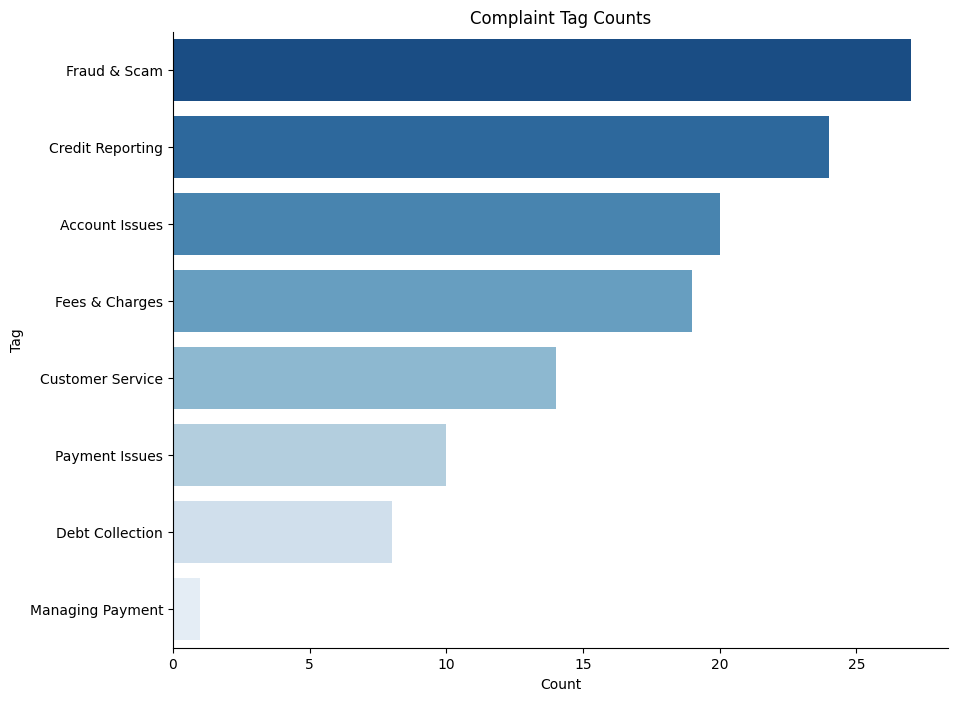

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
# Sort the data by count in descending order
complaints_tag_counts = df_client_customers.groupby('tag').size().reset_index(name='count').sort_values(by='count', ascending=False)


# Create a bar chart with color intensity based on count
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='tag', data=complaints_tag_counts, palette='Blues_r')
plt.title('Complaint Tag Counts')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()


### 📈 **Spend Forecast Time Series Using `AI.FORECAST`**  
- ⏳ Using `AI.FORECAST` in BigQuery ML to predict **6-month spending per client**.  
- ⚙️ The `AI.FORECAST` function in BigQuery provides high-quality time series forecasting without custom model training.  
- 📊 Derived **average forecasted spend** as a key engagement metric.  

---


In [ ]:
query = """
-- AI Forecast
CREATE OR REPLACE TABLE `my_database.timeseries_forecast_spend` as
SELECT *
FROM
  AI.FORECAST(
    (
      SELECT
        TIMESTAMP_TRUNC(date, month) as transaction_month,
      client_id,
      AVG(amount) AS avg_spend,
      FROM `my_database.transactions`
      GROUP BY 1,2
    ),
    horizon => 6,
    confidence_level => 0.95,
    timestamp_col => 'transaction_month',
    data_col => 'avg_spend',
    id_cols => ['client_id']);

CREATE OR REPLACE TABLE `my_database.timeseries_forecast_avg_spend` as
SELECT client_id, avg(forecast_value) as avg_spend_forecast
FROM `my_database.timeseries_forecast_spend`
GROUP BY 1;
"""

client.query(query).result()
print("✅ Table created successfully")


In [12]:
df_spend_f = client.query("select * from `my_database.timeseries_forecast_spend`").to_dataframe()
print(df_spend_f.shape)
df_spend_f.head(5)

(738, 7)


,client_id,forecast_timestamp,forecast_value,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,ai_forecast_status
0,338,2020-04-01 00:00:00+00:00,52.416489,0.95,41.192374,63.640603,
1,644,2019-12-01 00:00:00+00:00,40.160702,0.95,23.796858,56.524546,
2,644,2020-02-01 00:00:00+00:00,39.337959,0.95,22.673639,56.002279,
3,846,2020-02-01 00:00:00+00:00,40.760212,0.95,31.867855,49.652569,
4,1130,2020-04-01 00:00:00+00:00,52.328384,0.95,42.616801,62.039967,


#### **Plot Combined Spend Forecast For Client Id = 338**

- Captured monthly seasonality, revealing that this client demonstrates significantly higher spending during Thanksgiving and Christmas periods.

/tmp/ipython-input-570916490.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_transactions_monthly_spend = df_transactions_w_mcc.groupby(['client_id', pd.Grouper(key='date', freq='M')])['amount'].mean().reset_index()


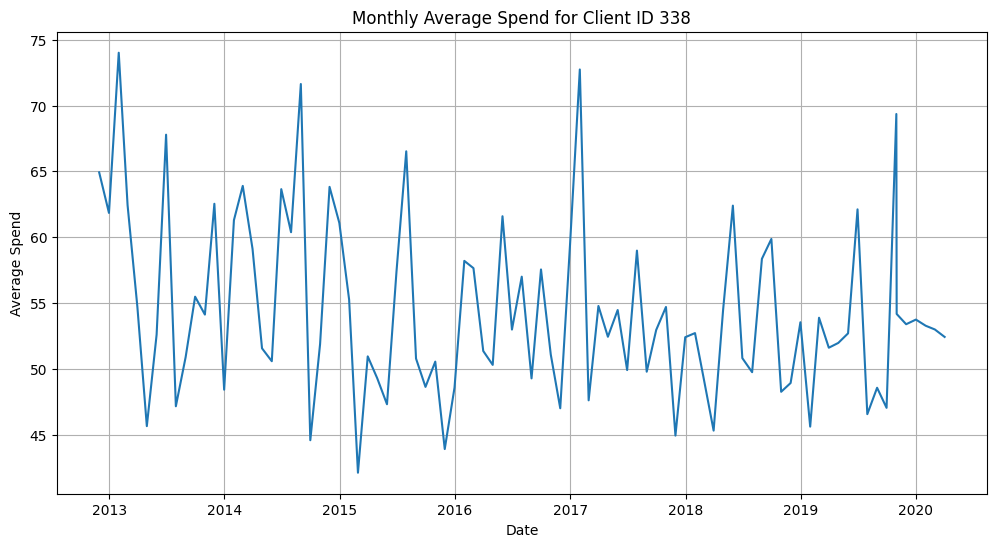

In [11]:
# Filter df_spend_f for client_id=338
df_spend_f_338 = df_spend_f[df_spend_f['client_id'] == 338].copy()

# Convert 'forecast_timestamp' to datetime for plotting
df_spend_f_338['forecast_timestamp'] = pd.to_datetime(df_spend_f_338['forecast_timestamp'])

# Group df_transactions_w_mcc by month and client_id and calculate average spend
df_transactions_monthly_spend = df_transactions_w_mcc.groupby(['client_id', pd.Grouper(key='date', freq='M')])['amount'].mean().reset_index()
df_transactions_monthly_spend.rename(columns={'date': 'forecast_timestamp', 'amount': 'forecast_value'}, inplace=True)

# Filter df_transactions_monthly_spend for client_id=338
df_transactions_monthly_spend_338 = df_transactions_monthly_spend[df_transactions_monthly_spend['client_id'] == 338].copy()

# Concatenate the two dataframes
df_combined_spend_338 = pd.concat([df_transactions_monthly_spend_338, df_spend_f_338[['forecast_timestamp', 'forecast_value']]], ignore_index=True)

# Sort by date for plotting
df_combined_spend_338 = df_combined_spend_338.sort_values('forecast_timestamp')

# Plot the monthly average spend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined_spend_338, x='forecast_timestamp', y='forecast_value')
plt.title('Monthly Average Spend for Client ID 338')
plt.xlabel('Date')
plt.ylabel('Average Spend')
plt.grid(True)
plt.show()


### 🎁 **Product Recommendation Engine Using `CREATE MODEL`**
- 👥 Built customer features (demographics, income, spend, credit, products used).  
- 🔍 Applied **K-Means clustering** with hyperparameter tuning (`HPARAM_RANGE(3,10)`).  
- 📌 Assigned each customer to a behavioral segment.  
- 🎯 Recommended new products to customers by ranking cluster-prevalent products not already owned.  
- 🧮 Generated a **recommendation strength %** for prioritization.  

---



In [ ]:
query = """
-----Builidng Customer Features
CREATE OR REPLACE TABLE `my_database.customer_features` AS
SELECT
  u.client_id,
  u.current_age as age,
  u.credit_score,
  u.total_debt,
  u.yearly_income,
  CASE WHEN u.gender = 'M' THEN 1 ELSE 0 END AS gender_m,
  COUNT(t.transaction_id) AS txn_count,
  round(AVG(t.amount),0) AS avg_spend,
  round(SUM(t.amount),0) AS total_spend,
  COUNT(DISTINCT c.product_type) AS unique_products,
  round(AVG(CASE WHEN t.fraud_label=1 THEN 1 ELSE 0 END),1) AS fraud_ratio,
  round(AVG(credit_score),0) as avg_cr,
  MAX(DATE_DIFF(DATE('2020-12-31'), PARSE_DATE('%m/%Y', acct_open_date), YEAR)) as years_since_open
FROM `my_database.users_data_sampled` u
LEFT JOIN `my_database.transactions_data_sampled` t ON u.client_id = t.client_id
LEFT JOIN `my_database.card_data_sampled` c ON t.client_id = c.client_id
GROUP BY 1,2,3,4,5,6
order by 1;

--- Customer Clusters
CREATE OR REPLACE MODEL `my_database.customer_clusters`
OPTIONS(
  model_type='kmeans',
  num_trials=5,                          -- how many models to train
  max_parallel_trials=2,                 -- run trials in parallel
  hparam_tuning_algorithm='RANDOM_SEARCH',
  NUM_CLUSTERS = HPARAM_RANGE(3,10),     -- search k between 3 and 10
  standardize_features=TRUE
) AS
SELECT * except(client_id)
FROM `my_database.customer_features`;


-- Assign Cluster to Customer
CREATE OR REPLACE TABLE `my_database.customer_segments` AS
SELECT
client_id,
CENTROID_ID as cluster_id
FROM ML.PREDICT(
  MODEL `my_database.customer_clusters`,
  TABLE `my_database.customer_features`
);



--Generate Product Recommendations
CREATE OR REPLACE TABLE `my_database.customer_product_recommendation` AS
WITH cluster_products AS (
  SELECT

    cs.cluster_id,
    c.product_type,
    COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY cs.cluster_id) AS product_share
  FROM `my_database.customer_segments` cs
  JOIN `my_database.card_data_sampled` c
  ON cs.client_id = c.client_id
  GROUP BY 1,2
),
current_user_products AS (
  SELECT DISTINCT client_id, product_type
  FROM `my_database.card_data_sampled`
)
SELECT * except(RNO) FROM
(SELECT
  cs.client_id,
  cp.product_type,
  round(cp.product_share*100,2) AS recommendation_strength,
  row_number() over(partition by cs.client_id order by cp.product_share desc) as rno
FROM `my_database.customer_segments` cs
LEFT JOIN cluster_products cp
  ON cs.cluster_id = cp.cluster_id
LEFT JOIN current_user_products up
  ON cs.client_id = up.client_id AND cp.product_type = up.product_type
WHERE up.product_type IS NULL -- To remove current product that the customer already has
ORDER BY cs.client_id, recommendation_strength DESC) T
WHERE RNO = 1;


"""

client.query(query).result()
print("✅ Table created successfully")


In [14]:
df_prod_recom = client.query("select * from `my_database.customer_product_recommendation`").to_dataframe()
print(df_prod_recom.shape)
df_prod_recom.head(5)

(123, 3)


,client_id,recommended_product,recommendation_strength
0,38,Visa - Credit,17.78
1,354,Mastercard - Credit,11.57
2,669,Visa - Debit,15.56
3,1261,Mastercard - Debit,41.30
4,1871,Visa - Debit,13.51


In [23]:
df_client_features = client.query("select * from `my_database.customer_features`").to_dataframe()
print(df_client_features.shape)

df_client_clusters = client.query("select * from `my_database.customer_segments`").to_dataframe()
print(df_client_clusters.shape)

df_client_features_w_clusters = pd.merge(df_client_features, df_client_clusters, on='client_id', how='left')
print(df_client_features_w_clusters.shape)
df_client_features_w_clusters

(123, 13)
(123, 2)
(123, 14)


,client_id,age,credit_score,total_debt,yearly_income,gender_m,txn_count,avg_spend,total_spend,unique_products,fraud_ratio,avg_cr,years_since_open,cluster_id
0,5,65,711,14042,20614,0,9554,61.0,585805.0,2,0.0,711.0,16,1
1,19,82,630,1336,34903,0,3268,17.0,54420.0,1,0.0,630.0,11,1
2,37,41,683,48954,34690,0,61100,26.0,1597599.0,2,0.0,683.0,11,2
3,38,45,621,72794,40006,0,13629,38.0,512966.0,1,0.0,621.0,13,2
4,40,71,726,30686,29243,0,25912,27.0,703963.0,4,0.0,726.0,22,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,1896,50,641,74352,40246,0,69890,28.0,1928457.0,3,0.0,641.0,18,5
119,1897,38,741,247623,104049,0,28614,49.0,1390336.0,2,0.0,741.0,19,6
120,1962,34,712,156949,92375,0,57835,51.0,2920689.0,3,0.0,712.0,14,3
121,1964,68,643,30595,38637,0,42856,40.0,1696212.0,3,0.0,643.0,14,7


In [22]:
# Select numerical features for PCA
features = ['age', 'credit_score', 'total_debt', 'yearly_income', 'txn_count', 'avg_spend', 'total_spend', 'unique_products', 'fraud_ratio', 'avg_cr', 'years_since_open']
df_pca_features = df_client_features_w_clusters[features]

# Handle potential NaN or inf values (optional, depending on data)
df_pca_features = df_pca_features.replace([np.inf, -np.inf], np.nan).dropna()


# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_pca_features)

# Apply PCA with 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)

# Create a new DataFrame with the principal components and cluster_id
df_pca = pd.DataFrame(data = principal_components, columns = ['principal_component_1', 'principal_component_2', 'principal_component_3'])

# Add the cluster_id back to the PCA dataframe, ensuring alignment with the features used for PCA
df_pca['cluster_id'] = df_client_features_w_clusters.loc[df_pca_features.index, 'cluster_id'].astype(str).values # Convert cluster_id to string for discrete colors


# Plot the interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df_pca,
                    x='principal_component_1',
                    y='principal_component_2',
                    z='principal_component_3',
                    color='cluster_id',
                    title='Customer Clusters after PCA (Interactive 3D)')
fig.show()


## 🌐 **Full Customer 360 View**
- 🔗 Combined fraud risk, spend forecasts, recommendations, and complaints into a single `Customer360` table.  
- 🤖 Used `AI.GENERATE` to craft **actionable next-best-action summaries** for bankers in one sentence.  

---


In [ ]:
query = """
CREATE OR REPLACE TABLE `my_database.customer360` AS
WITH transactions_summary AS (
      SELECT client_id,
      count(transaction_id) AS txn_count,
      avg(amount) as avg_txn_amt,
      SUM(amount) AS total_spend,
      AVG(fraud_label) AS fraud_score
      FROM `my_database.transactions`
      group by 1
)
SELECT
*,
  AI.GENERATE(
    CONCAT(
      "You are a customer success AI agent at a Bank. Based on this customer profile:\n",
      "Avg transaction amount: ", CAST(coalesce(t.avg_txn_amt,0) AS STRING), "\n",
      "Avg predicted future transaction: ", CAST(coalesce(tf.avg_spend_forecast) AS STRING), "\n",
      "Chance of fraud: ", CAST(coalesce(t.fraud_score) AS STRING), "\n",
      "What customer complained about: ", coalesce(cs.tag,"None"), "\n",
      "Recommended New Product based on clustering: ", coalesce(p.recommended_product,"None"), "\n",
      "Suggest the next best action in 1 sentence for increasing customer engagement and improving overall satisfaction."
    ),
    connection_id => 'us.my_vertex_connection',
    endpoint => 'gemini-2.5-flash',
    output_schema => 'recommendation STRING').recommendation,

FROM `my_database.sample_client_ids` s
LEFT JOIN transactions_summary t USING (client_id)
LEFT JOIN `my_database.complaints_tagging` cs USING (client_id)
LEFT JOIN `my_database.timeseries_forecast_avg_spend` tf USING (client_id)
LEFT JOIN `my_database.customer_product_recommendation` p USING (client_id);
"""

client.query(query).result()
print("✅ Table created successfully")


In [32]:
df_c360 = client.query("select * from my_database.customer360").to_dataframe()
print(df_c360.shape)
df_c360.head(5)

(123, 29)


,client_id,CLIENT_ID_PROXY,txn_count,avg_txn_amt,total_spend,fraud_score,date_received,product,subproduct,issue,...,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,tag,avg_spend_forecast,recommended_product,recommendation_strength,recommendation
0,1896,119,13978,27.592739,385691.31,0.000787,2021-12-09,Checking or savings account,Checking account,Closing an account,...,2021-12-09,Closed with non-monetary relief,True,<NA>,4994313,Customer Service,27.849839,Mastercard - Debit,33.06,Prioritize direct outreach to address their cu...
1,1709,111,6378,42.390428,270366.15,0.002195,2022-08-15,Checking or savings account,Checking account,Managing an account,...,2022-08-15,Closed with explanation,True,<NA>,5879252,Account Issues,36.321394,Visa - Debit,13.51,Proactively address the customer's account iss...
2,895,67,8604,38.993323,335498.55,0.000000,2022-12-15,Checking or savings account,Checking account,Problem with a lender or other company chargin...,...,2022-12-15,Closed with explanation,True,<NA>,6325300,Fraud & Scam,37.524291,Visa - Debit,32.93,Proactively reach out to the customer to discu...
3,104,11,7469,51.352956,383555.23,0.001339,2021-12-01,Checking or savings account,Checking account,Closing an account,...,2021-12-01,Closed with monetary relief,True,<NA>,4964555,Fees & Charges,52.095137,Visa - Debit,32.93,"To increase engagement and satisfaction, direc..."
4,1962,121,11567,50.500380,584137.89,0.000173,2023-01-19,Checking or savings account,Checking account,Problem caused by your funds being low,...,2023-01-19,Closed with explanation,True,<NA>,6457018,Fees & Charges,50.009822,Mastercard - Credit,9.47,Proactively reach out to the customer to discu...


In [34]:
pd.set_option('display.max_colwidth', None)
display(df_c360[['client_id','recommendation']])

,client_id,recommendation
0,1896,Prioritize direct outreach to address their customer service complaint and offer a personalized explanation of the recommended Mastercard Debit's benefits to enhance their banking experience.
1,1709,Proactively address the customer's account issues with a dedicated follow-up and introduce the benefits of the Visa Debit card to enhance their banking experience.
2,895,"Proactively reach out to the customer to discuss enhanced security features of their accounts and the recommended Visa Debit card, directly addressing past fraud concerns to rebuild trust and foster engagement."
3,104,"To increase engagement and satisfaction, directly address the customer's complaint about Fees & Charges by discussing solutions and the benefits of the recommended Visa Debit card."
4,1962,"Proactively reach out to the customer to discuss how a Mastercard Credit card with transparent, competitive fees could benefit them, directly addressing their past concerns about fees and charges to improve satisfaction and engagement."
...,...,...
118,729,"Address the customer's complaint regarding fees by reviewing their current account structure and presenting the value proposition of the recommended Amex Credit card, highlighting potential fee waivers or rewards that could enhance their banking experience."
119,1794,Address the customer's fee complaint by reviewing their current charges and offering the recommended Visa - Credit card with transparent and competitive fee structures to enhance engagement and satisfaction.
120,705,"Proactively offer the customer the recommended Mastercard Debit card, emphasizing its transparent or reduced fee structure to directly address their past complaint about Fees & Charges and enhance overall satisfaction."
121,797,"Initiate a personalized call to address their recent fraud and scam concerns, highlight enhanced security protocols, and introduce the recommended Mastercard - Credit card's fraud protection benefits."



## 📊 **Results**  
- 👥 123 clients, ~1.2M transactions sampled.  
- 🛡 Fraud risk scores highlight high-risk customers for intervention.  
- 📈 Forecasts provide visibility into future spend with 95% confidence.  
- 🎯 Cluster-based recommendations achieved explainable product suggestions with measurable strength.  
- 💬 LLM-tagged complaints gave human-readable insights into customer pain points in 2–3 seconds.  
- 🏦 **Customer360 view acts as a one-stop tool for bankers**: churn risk, fraud score, predicted spend, product recommendation, and AI-generated action advice.  

---

## 🚀 **Future Work**
- 📊 **AI-powered Looker dashboard** for bankers and customer service reps, enabling real-time insights and next-best-action recommendations.  
- 🔎 **Embedding-based similarity search** to deliver smarter and more personalized product recommendations.  
- 🏦 **Deployment on real banking data**, with advanced data cleaning and validation to ensure production readiness.  
- 🖼 **Multi-modal feature integration in BigQuery**, enabling the use of handwritten notes or photo attachments from customer complaints for richer insights.  

---